<a href="https://colab.research.google.com/github/PiKaChu-wcg/pytorch/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import requests
import torch
import torch.nn as nn
import re 
import jieba
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [2]:
good_file='/content/drive/MyDrive/pytorch/good.txt'
bad_file='/content/drive/MyDrive/pytorch/bad.txt'

In [3]:
def filter_punc(sentence):
    sentence = re.sub("[\s+\.\!\/_,$%^*(+\"\'“”《》?“]+|[+——！，。？、~@#￥%……&*（）：]+", "", sentence)  
    return(sentence)

In [4]:
def Preapre_data(good_file,bad_file,is_filter=True):
    all_words=[]
    pos_sentences=[]
    neg_sentences=[]
    with open(good_file,'r',encoding='utf-8') as fr:
        for idx,line in enumerate(fr):
            if is_filter:
                line=filter_punc(line)
                words=jieba.lcut(line)
                if len(words):
                    all_words+=words
                    pos_sentences.append(words)
    print('{0}包含{1}行{2}个词'.format(good_file,idx+1,len(all_words)))
    count=len(all_words)
    with open(bad_file,'r',encoding='utf-8') as fr:
        for idx,line in enumerate(fr):
            if is_filter:
                line=filter_punc(line)
                words=jieba.lcut(line)
                if len(words):
                    all_words+=words
                    neg_sentences.append(words)
    print('{0}包含{1}行{2}个词'.format(bad_file,idx+1,len(all_words)-count))
    diction={}
    cnt=Counter(all_words)
    for word,freq in cnt.items():
        diction[word]=[len(diction),freq]
    print("{}".format(len(diction)))
    return(pos_sentences,neg_sentences,diction)

In [5]:
pos_sentences,neg_sentences,diction=Preapre_data(good_file,bad_file)
st=sorted([(v[1],w) for w,v in diction.items()])

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.767 seconds.
Prefix dict has been built successfully.


/content/drive/MyDrive/pytorch/good.txt包含8089行100839个词
/content/drive/MyDrive/pytorch/bad.txt包含5076行56070个词
7135


In [6]:
def word2idx(word,diction):
    if word in diction:
        value=diction[word][0]
    else:
        value=-1
    return value
def idx2word(idx,diction):
    for w,v in diction.items():
        if v[0]==idx:
            return(w)
    return(None)
def sentence2vec(sentence,diction):
    vector=np.zeros(len(diction))
    for l in sentence:
        vector[l]+=1
    return(1.0*vector/len(sentence))

In [7]:
dataset=[]
labels=[]
sentences=[]
for sentence in pos_sentences:
    new_sentence=[]
    for l in sentence:
        if l in diction:
            new_sentence.append(word2idx(l,diction))
    dataset.append(sentence2vec(new_sentence,diction))
    labels.append(0)
    sentences.append(sentence)
for sentence in neg_sentences:
    new_sentence=[]
    for l in sentence:
        if l in diction:
            new_sentence.append(word2idx(l,diction))
    dataset.append(sentence2vec(new_sentence,diction))
    labels.append(1)
    sentences.append(sentence)
indices=np.random.permutation(len(dataset))
dataset = [dataset[i] for i in indices]
labels=[labels[i] for i in indices]
sentences=[sentences[i] for i in indices]

In [8]:
test_size = len(dataset) // 10
train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

valid_data = dataset[: test_size]
valid_label = labels[: test_size]

test_data = dataset[test_size : 2 * test_size]
test_label = labels[test_size : 2 * test_size]

In [9]:
# 一个简单的前馈神经网络，三层，第一层线性层，加一个非线性ReLU，第二层线性层，中间有10个隐含层神经元

# 输入维度为词典的大小：每一段评论的词袋模型
model = nn.Sequential(
    nn.Linear(len(diction), 10),
    nn.ReLU(),
    nn.Linear(10, 2),
    nn.LogSoftmax(dim=1),
)

def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

In [14]:
# 损失函数为交叉熵
cost = torch.nn.NLLLoss()
# 优化算法为Adam，可以自动调节学习率
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
records = []
cost=cost.cuda()
model=model.cuda()
#循环10个Epoch
losses = []
for epoch in range(10):
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        
        # 需要将输入的数据进行适当的变形，主要是要多出一个batch_size的维度，也即第一个为1的维度
        x = torch.tensor(x, requires_grad = True, dtype = torch.float).view(1,-1).cuda()
        # x的尺寸：batch_size=1, len_dictionary
        # 标签也要加一层外衣以变成1*1的张量
        y = torch.tensor(np.array([y]), dtype = torch.long).cuda()
        # y的尺寸：batch_size=1, 1
        
        # 清空梯度
        optimizer.zero_grad()
        # 模型预测
        predict = model(x)
        # 计算损失函数
        loss = cost(predict, y)
        # 将损失函数数值加入到列表中
        losses.append(loss.cpu().data.numpy())
        # 开始进行梯度反传
        loss.backward()
        # 开始对参数进行一步优化
        optimizer.step()
        
        # 每隔3000步，跑一下校验数据集的数据，输出临时结果
        if i % 3000 == 0:
            val_losses = []
            rights = []
            # 在所有校验数据集上实验
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = torch.tensor(x, requires_grad = True, dtype = torch.float).view(1,-1).cuda()
                y = torch.tensor(np.array([y]), dtype = torch.long).cuda()
                predict = model(x)
                # 调用rightness函数计算准确度
                right = rightness(predict, y)
                rights.append(right)
                loss = cost(predict, y)
                val_losses.append(loss.cpu().data.numpy())
                
            # 将校验集合上面的平均准确度计算出来
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 校验损失：{:.2f}, 校验准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])
            

第0轮，训练损失：0.75, 校验损失：0.70, 校验准确率: 0.37
第0轮，训练损失：0.39, 校验损失：0.35, 校验准确率: 0.90
第0轮，训练损失：0.36, 校验损失：0.33, 校验准确率: 0.89
第0轮，训练损失：0.34, 校验损失：0.33, 校验准确率: 0.90
第1轮，训练损失：0.33, 校验损失：0.34, 校验准确率: 0.90
第1轮，训练损失：0.32, 校验损失：0.35, 校验准确率: 0.90
第1轮，训练损失：0.31, 校验损失：0.34, 校验准确率: 0.90
第1轮，训练损失：0.30, 校验损失：0.33, 校验准确率: 0.91
第2轮，训练损失：0.30, 校验损失：0.34, 校验准确率: 0.90
第2轮，训练损失：0.29, 校验损失：0.36, 校验准确率: 0.90
第2轮，训练损失：0.29, 校验损失：0.35, 校验准确率: 0.90
第2轮，训练损失：0.28, 校验损失：0.33, 校验准确率: 0.90
第3轮，训练损失：0.28, 校验损失：0.35, 校验准确率: 0.90
第3轮，训练损失：0.27, 校验损失：0.37, 校验准确率: 0.90
第3轮，训练损失：0.27, 校验损失：0.36, 校验准确率: 0.90
第3轮，训练损失：0.27, 校验损失：0.33, 校验准确率: 0.90
第4轮，训练损失：0.27, 校验损失：0.35, 校验准确率: 0.90
第4轮，训练损失：0.26, 校验损失：0.37, 校验准确率: 0.90
第4轮，训练损失：0.26, 校验损失：0.35, 校验准确率: 0.90
第4轮，训练损失：0.26, 校验损失：0.33, 校验准确率: 0.90
第5轮，训练损失：0.26, 校验损失：0.36, 校验准确率: 0.90
第5轮，训练损失：0.25, 校验损失：0.36, 校验准确率: 0.90
第5轮，训练损失：0.25, 校验损失：0.36, 校验准确率: 0.89
第5轮，训练损失：0.25, 校验损失：0.33, 校验准确率: 0.90
第6轮，训练损失：0.25, 校验损失：0.38, 校验准确率: 0.90
第6轮，训练损失：0.25, 校验损失：0.37, 校验准确率: 0.90
第6轮，训练损失：0.2

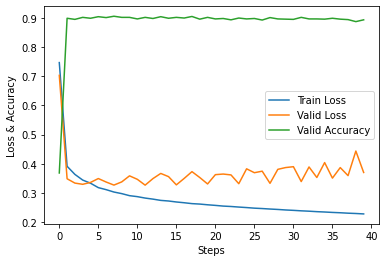

In [15]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()  

In [17]:
vals=[]
for data,target in zip(test_data,test_label):
    data,target=torch.tensor(data,dtype=torch.float).view(1,-1),torch.tensor(np.array([target]),dtype=torch.long)
    output=model.cpu()(data)
    val=rightness(output,target)
    vals.append(val)
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].data.numpy() / rights[1]
right_rate

0.898695318495779

In [20]:
for i in range(len(model[0].weight)):
    print('\n')
    print('第{}个神经元'.format(i))
    print('max:')
    st = sorted([(w,i) for i,w in enumerate(model[0].weight[i].data.numpy())])
    for i in range(1, 20):
        word = idx2word(st[-i][1],diction)
        print(word)
    print('min:')
    for i in range(20):
        word = idx2word(st[i][1],diction)
        print(word)



第0个神经元
max:
耐心
试穿
优惠
棒
仔细
相当
nbsp
哟
顶
试
划算
quot
起来
期望值
外观
包装
下手
棒棒
上档次
min:
差
差评
垃圾
很差
上当
哎
发错
不如
难看
一股
月
千万别
不能
不好
歪
差差
骗人
为什么
醉
单大


第1个神经元
max:
失去
卧槽
身材
拍个
春光明媚
推荐
好看
可算松
卖出
嫲
我刚
油迹
看点
决定
变长
有球
服务质量
发汗
美眉
min:
所见
购买
所得
值得
既
涤纶
规范
摖
购物
快递费
薄如纸
出现
有点儿
里
一件
那
潮流
一号
12
另外


第2个神经元
max:
顶
光顾
亲身经历
我用
耐心
朋友
力
划算
点赞
nbsp
棒
男朋友
托
开心
超好
quot
就是
仔细
需要
min:
差评
差
不想
骗
垃圾
醉
不
不理
难看
发
退
不会
烂
骗人
最差
不如
破
宝贝
不值
差劲


第3个神经元
max:
工地
越来越
直得
黑黑的
high
特备
解答
巴
问
看咯
一提
磕碰
fashion
好些
别的
纳闷
力祝
真水
留意
min:
问题
满意
收到
后
死去
分不多
拿错
清理
大好
不服
劣质
棉太硬
太棒
挺
划痕
～
还好
几次
倾吾之
要死


第4个神经元
max:
海绵
奇差
这样
捂汗
这多
这边
爱好
量身定做
当场
要用
刮
弓村
劝
想
绝对
可气
小差
吓死人
商量
min:
si
久
好头
残次品
洗不掉
158105
一班
轻
小脚
黑道
常
没
东西
棉衣
没什么
大骗子
感觉良好
现钱
结果显示
上课


第5个神经元
max:
耐心
划算
nbsp
期望值
顶
棒棒
quot
优惠
棒
超值
开心
严实
仔细
完全一致
上档次
我用
亲身经历
试
YY
min:
差评
很差
差劲
太大
不如
地摊货
最差
一股
一个月
一星
不好
严重
烂
哎
发错
骗人
一句
千万
痒
竟然


第6个神经元
max:
划算
顶
气质
我用
亲身经历
nbsp
蛮
点赞
男朋友
仔细
耐心
力
超值
款
谢谢
信赖
托
一款
需要
min:
垃圾
差评
退货
不想
发
难看
哪里
差劲
五天
太差
月
退
两个
直接
半个
一个月
没到
没法
肯定
却


第7个神经元
max:
优质
別買
醉
风风火火
不诚实
单党

In [21]:
wrong_sentences = []
targets = []
j = 0
sent_indices = []
for data, target in zip(test_data, test_label):
    predictions = model(torch.tensor(data, dtype = torch.float).view(1,-1))
    pred = torch.max(predictions.data, 1)[1]
    target = torch.tensor(np.array([target]), dtype = torch.long).view_as(pred)
    rights = pred.eq(target)
    indices = np.where(rights.numpy() == 0)[0]
    for i in indices:
        wrong_sentences.append(data)
        targets.append(target[i])
        sent_indices.append(test_size + j + i)
    j += len(target)

In [23]:
idx = 1
print(sent_indices)
print(sentences[sent_indices[idx]])
print(targets[idx].numpy())
lst = list(np.where(wrong_sentences[idx]>0)[0])
mm = list(map(lambda x:idx2word(x, diction), lst))
print(mm)

[1316, 1323, 1330, 1344, 1357, 1367, 1370, 1376, 1378, 1388, 1395, 1397, 1410, 1417, 1418, 1423, 1425, 1434, 1440, 1445, 1462, 1468, 1475, 1488, 1491, 1508, 1519, 1524, 1527, 1532, 1533, 1537, 1542, 1556, 1562, 1568, 1593, 1647, 1649, 1670, 1692, 1694, 1701, 1709, 1722, 1737, 1740, 1758, 1770, 1772, 1789, 1798, 1806, 1815, 1817, 1831, 1882, 1883, 1889, 1902, 1905, 1915, 1921, 1959, 1966, 1968, 1970, 1973, 1976, 1981, 2006, 2008, 2028, 2032, 2042, 2058, 2064, 2084, 2094, 2098, 2117, 2137, 2138, 2150, 2157, 2161, 2171, 2193, 2205, 2240, 2252, 2254, 2258, 2278, 2281, 2303, 2327, 2335, 2359, 2364, 2385, 2391, 2393, 2401, 2412, 2417, 2418, 2426, 2444, 2445, 2448, 2454, 2460, 2472, 2473, 2481, 2484, 2491, 2502, 2526, 2529, 2530, 2531, 2545, 2551, 2559, 2568, 2577, 2578, 2590, 2591, 2600]
['我', '不', '小心', '点', '了', '确认', '收货', '但是', '货', '一直', '没有', '收到', '钱', '给', '了']
1
['我', '了', '没有', '不', '收到', '给', '但是', '货', '确认', '收货', '钱', '一直', '点', '小心']
